# Quantum Time Series Analysis: Overloading SW QTSA Model
Compatible with Qiskit 1.2.4+

### Author
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.2.4+ 

### Aims
> *This script aims to fit time series data with quantum neural network.*

### Primary Sources
- Schreiber, Amelie. “Quantum Neural Networks for FinTech.” 
    Medium, May 8, 2020.<br/> 
    https://towardsdatascience.com/quantum-neural-networks-for-fintech-dddc6ac68dbf
- Qiskit Team. "Tutorial: Neural Network Classifier & Regressor", Last updated: 31 Aug 2022.<br/>
    https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
### Libraries used in QTSA development

from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap,EfficientSU2, PauliFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.utils.loss_functions import L1Loss, L2Loss
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

In [4]:
### Listing control
debug = True
seed = 2022

### Software version
MAJOR = 9
MINOR = 0

### Constants
LOG_NAME = 'log_2'
CASE_NAME = 'sliding'
DATA_NAME = '2_sins_sw'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'sliding',
 '2_sins_sw',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Fetch data

In [5]:
### All created files have the following codes:
DATA_ID = '2_sins_sw_t50_v20_z0_w5_s1_h1'

### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_ID}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_ID}/y_all.arr'

x_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_train_ts.arr'
y_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_train_ts.arr'
x_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_valid_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_valid_ts.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info_fpath

'log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json'

In [6]:
### Load the info file
data_info = read_json_file(data_info_fpath)
    
### Get info details
DATA_NAME = data_info['data_name']
DATA_MAJOR = data_info['major_version'] 
DATA_MINOR = data_info['minor_version']
samples_train = data_info['data_train']
samples_valid = data_info['data_valid']
noise = data_info['data_noise']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['wind_horizon']
seed = data_info['seed']
samples = samples_train + samples_valid
train_pc = samples_train / samples

print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()
print(f'\tcalc[samples] = {samples}')
print(f'\tcalc[train_pc] = {train_pc}')
print()


Saved time series info in file "log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json":

	info[data_name] = 2_sins_sw
	info[major_version] = 9
	info[minor_version] = 0
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0
	info[wind_size] = 5
	info[wind_step] = 1
	info[wind_horizon] = 1
	info[seed] = 2022

	calc[samples] = 70
	calc[train_pc] = 0.7142857142857143



In [7]:
### Load data files
X_all = read_ts_file(x_all_fpath)[..., None]
y_all = read_ts_file(y_all_fpath)
X_train_ts = read_ts_file(x_train_ts_fpath)
y_train_ts = read_ts_file(y_train_ts_fpath)[..., None]
X_valid_ts = read_ts_file(x_valid_ts_fpath)
y_valid_ts = read_ts_file(y_valid_ts_fpath)[..., None]
print(f'\nLoaded time series data\n')


Loaded time series data





TS noise = 0%, calculated noise in differenced TS = 0.0%, total noise = 0.0, over the points = 46



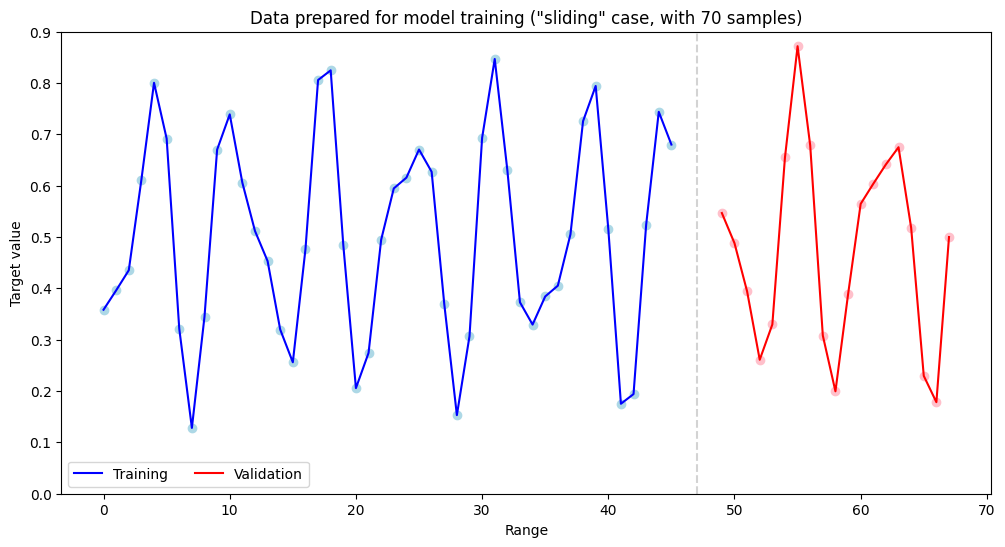

In [8]:
### Plot of training and validation data with noise
itg_integrated_plot(y_train_ts, y_valid_ts, y_train_ts, y_valid_ts, wind_step, noise,
     labels=['Training', 'Validation'], xlabel='Range', ylabel='Target value', ylim=(0, 0.9),
     title=f'Data prepared for model training ("{CASE_NAME}" case, with {samples} samples)',
     # line_styles={'train_pure':'solid', 'train_noisy':'none', 'valid_pure':'solid', 'valid_noisy':'none'},
     cols = {'train_pure':'blue', 'train_noisy':'lightblue', 'valid_pure':'red', 'valid_noisy':'pink'},
     marker_style='o')
print()

## Overloading Sliding Windows QTSA Qiskit Solution

### Identify device

In [9]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available quantum devices: {devices}')

### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device
print(f'Selected device: {device}')

Available quantum devices: ('CPU', 'GPU')
Selected device: CPU


In [10]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

### Sliding window ansatz


Input params#: 15, Weight params#: 90, Layer#: x2 * i2 = 4



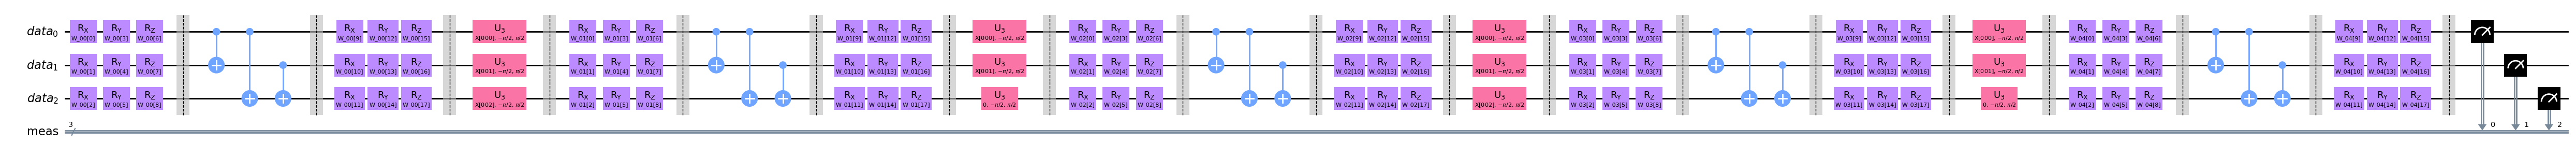

In [11]:
### Serial sliding window ansatz
#   - To be used with CircuitQNN / NeuralNetworkRegressor
#
#   inputs
#     qubit_no: The number of qubits in the circuit
#     input_no: The number of input values / the size of a sliding window
#     xlayers: The number of "external" ansatz layers
#     add_meas: If true measurements will be added
#     ent: Types of entanglements to be used
#
#   returns
#     Circuit: The serial sliding window ansatz 
#     SParams: The list of parameters used in all S blocks
#     WParams: The list of parameters used in all W blocks
#     Layers: The calculated number of "internal" layers in the circuit

def swindow_serial_model(qubit_no, input_no, xlayers=1, add_meas=False, ent='circular'):

    SLabel = 'X'
    WLabel = 'W'
    
    ilayers = input_no // qubit_no + (0 if input_no % qubit_no == 0 else 1)
    used_sgates = 0

    # Predefined all S parameters
    SParams = []
    for q in range(input_no):
        param_x = Parameter(f'{SLabel}[{q:03d}]')
        SParams.append(param_x)

    ### Create an ansatz
    qr = QuantumRegister(qubit_no, 'data')
    ansatz = QuantumCircuit(qr, name='ansatz')
    WParams = []

    # Data-encoding circuit block, packs different input vars
    def SN(qubit_no):
        nonlocal used_sgates, SParams
        s_qr = QuantumRegister(qubit_no)
        s_ansatz = QuantumCircuit(s_qr, name='SSM')
        for q in range(qubit_no):
            param_x = SParams[q] if used_sgates < input_no else 0
            s_ansatz.rx(param_x, q)
            used_sgates += 1
        return s_ansatz

    # Trainable circuit block
    def W(qubit_no, label):
        w_qr = QuantumRegister(qubit_no)
        w_ansatz = QuantumCircuit(w_qr, name='W')
        w_ansatz.append(
            TwoLocal(qubit_no, ['rx', 'ry', 'rz'], 'cx', 
                     entanglement=ent,
                     reps=1, 
                     parameter_prefix=label, 
                     insert_barriers=True,
                     skip_final_rotation_layer=False),
            qargs=w_qr)
        return w_ansatz

    used_wlayers = 0
    for xl in range(xlayers):
        used_sgates = 0
        
        for il in range(ilayers):
            W1 = W(qubit_no, f'W_{used_wlayers:02d}')
            used_wlayers += 1
            WParams = WParams + W1.parameters[:]
            ansatz.append(W1, qargs=qr)
            ansatz.barrier()
            SX = SN(qubit_no) # , 'X'+str(il))
            SParams = SParams + SX.parameters[:]
            ansatz.append(SX, qargs=qr)
            ansatz.barrier()
    
        if xl == xlayers-1:
            W1 = W(qubit_no, f'W_{used_wlayers:02d}')  
            used_wlayers += 1
            WParams = WParams + W1.parameters[:]
            ansatz.append(W1, qargs=qr)

    if add_meas:
        ansatz.measure_all()

    return ansatz.decompose().decompose().decompose(), SParams, WParams, ilayers

# Test a sample serial ansatz
qubits_no = 3; input_no = 5; xlayers = 2
m, input_params, weight_params, ilayers = swindow_serial_model(qubits_no, input_no, xlayers, ent='full', add_meas=True)

# print(f'Layers: {ilayers}\nParams: {m.parameters}\n')
# print('Input params:\n', input_params)
# print('\nWeight params:\n', weight_params)
print(f'\nInput params#: {len(input_params)}, Weight params#: {len(weight_params)}, Layer#: x{xlayers} * i{ilayers} = {xlayers*ilayers}')

m.draw(output='mpl', style='clifford', fold=False, scale=1)
print()

## Create and train the model

In [ ]:
# Define model parameters and their initial values (including random input)

epochs = 60
log_interval = 1
prompt_interval = 3
qubits = 3
inputs = X_train_ts.shape[1]
xlayers = 2
ent = 'circular'

In [32]:
### Utility

# Define output interpretations (sampler)
output_shape = 2
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2
identity_interpret = lambda x: x

# Define observables (estimator)
op = SparsePauliOp.from_list([("Z" * qubits, 1)]) 
op1 = SparsePauliOp.from_list([("I" * qubits, 0.5), ("Z" * qubits, 0.5)])
op2 = SparsePauliOp.from_list([("I" * qubits, 0.5), ("Z" * qubits, -0.5)])

In [34]:
### Create a model

model, input_params, weight_params, ilayers = \
        swindow_serial_model(qubits, inputs, xlayers, ent=ent)
init_weights = 2 * np.pi * algorithm_globals.random.random(model.num_parameters-inputs)

In [37]:
### Define a regressor

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Construct SWSM and show its circuit
regr_qnn = EstimatorQNN(
    circuit=model,
    input_params=model.parameters[:inputs],
    weight_params=model.parameters[inputs:],
    observables=op, # [op1, op2],
    estimator=estimator
)

print(f'Window size={wind_size}, Horizon={horizon}, Qubits={qubits}, Layers=(x:{xlayers}, i:{ilayers})\n')

### Define a regressor
algorithm_globals.random_seed = 2022
np.random.seed(seed)

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500) - very fast
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500) - slower
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16) - slowwweeer
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks

loss_fun = L2Loss() # L1Loss() # 
loss_fun_name = 'L2Loss' # 'L1Loss' # 

optimizer = L_BFGS_B(maxiter=epochs) # COBYLA(maxiter=epochs) # Previously 50
progress_bar = tqdm(total=epochs, desc='SW QTSA training epoch: ')
regr_callback = Regr_callback(log_interval=log_interval, prompt_interval=prompt_interval, tqdm_progress=progress_bar)

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss=loss_fun,
    optimizer=optimizer, 
    initial_point=init_weights, 
    # callback=regr_callback.objfun_graph
    callback=regr_callback.objfun_print
)

Window size=5, Horizon=1, Qubits=3, Layers=(x:2, i:2)



SW QTSA training epoch:   0%|          | 0/60 [00:00<?, ?it/s]

In [38]:
### Train the model

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Fit to data and plot progress
print(f'\nOptimum model calculation\n')

# Fit to data and plot progress
start = time.time()

# fit regressor
regressor.fit(X_train_ts, np.array([y[0] for y in y_train_ts])) 
elapsed = time.time() - start

### Find the optimum objective fun value and NN weights
min_obj = regr_callback.min_obj()
print(f'Optimum objective value: {np.round(min_obj[1], 4)} @ {min_obj[0]*log_interval} (time={np.round(elapsed, 0)} secs)')


Optimum model calculation

Results:   epoch=    3, min cost / real=0.02690 / logged=0.02690   @     1
Results:   epoch=    6, min cost / real=0.01680 / logged=0.01680   @     5
Results:   epoch=    9, min cost / real=0.01380 / logged=0.01380   @     8
Results:   epoch=   12, min cost / real=0.01100 / logged=0.01100   @    11
Results:   epoch=   15, min cost / real=0.00890 / logged=0.00890   @    14
Results:   epoch=   18, min cost / real=0.00720 / logged=0.00720   @    17
Results:   epoch=   21, min cost / real=0.00610 / logged=0.00610   @    20
Results:   epoch=   24, min cost / real=0.00580 / logged=0.00580   @    23
Results:   epoch=   27, min cost / real=0.00570 / logged=0.00570   @    26
Results:   epoch=   30, min cost / real=0.00550 / logged=0.00550   @    29
Results:   epoch=   33, min cost / real=0.00550 / logged=0.00550   @    32
Results:   epoch=   36, min cost / real=0.00540 / logged=0.00540   @    34
Results:   epoch=   39, min cost / real=0.00530 / logged=0.00530   @    

In [39]:
### Collect all training history
params_vals = np.array(regr_callback.params_vals)
objfun_vals = np.array(regr_callback.objfun_vals)
print(f'Param shape: {params_vals.shape}, Obj fun shape={objfun_vals.shape}')

Param shape: (68, 88), Obj fun shape=(68,)


## Analysis and reporting

In [40]:
### Training parameters

### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   fm: number of fm layers
#   anz: number of ansatz layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
opt_name = optimizer.setting.splitlines()[0][11:]
TRAIN_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{model.num_qubits}_xl{xlayers}_il{ilayers}_'+\
             f'{opt_name}_ep{epochs}'
TRAIN_PREF

'sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60'

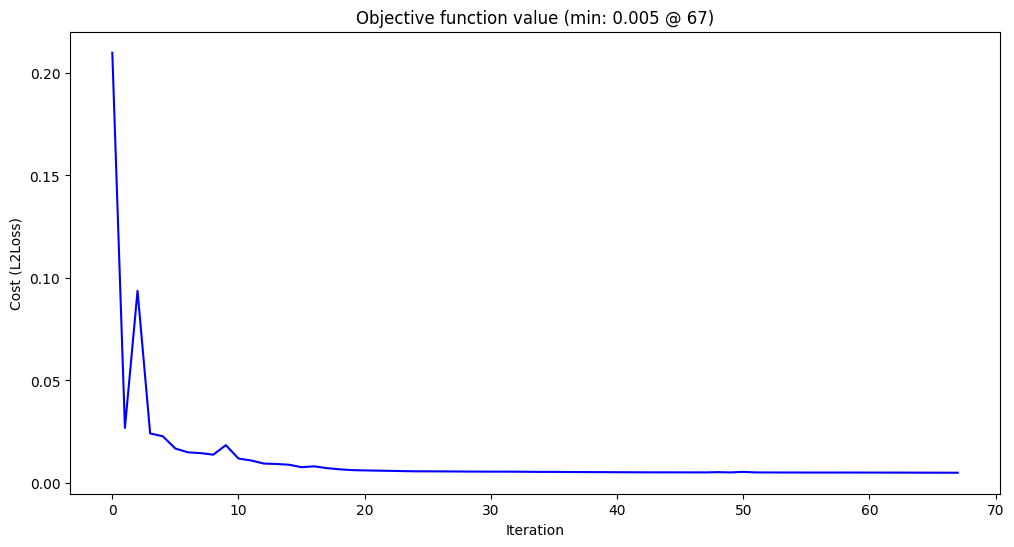

In [42]:
regr_callback.plot(
    ylabel = f'Cost ({loss_fun_name})', 
    save_plot = f'{FIGURES_PATH}/train_{TRAIN_PREF}/hist_{loss_fun_name}.eps')

## Analysis and reporting

In [43]:
### Reconstruct training prefix
ANALYSIS_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{model.num_qubits}_xl{xlayers}_il{ilayers}_'+\
                f'{opt_name}_ep{epochs}'
ANALYSIS_PREF

'sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60'

### Score the model

In [63]:
### Calculate the final score

yp_train_true = y_train_ts
yp_valid_true = y_valid_ts

yp_train_hat = regressor.predict(X_train_ts)
yp_valid_hat = regressor.predict(X_valid_ts)

train_r2 = r2_score(yp_train_true, yp_train_hat)
train_mae = mean_absolute_error(yp_train_true, yp_train_hat)
print('\nTraining   R2:\t', train_r2, '\nTraining   MAE:\t', train_mae)

valid_r2 = r2_score(yp_valid_true, yp_valid_hat)
valid_mae = mean_absolute_error(yp_valid_true, yp_valid_hat)
print('\nValidation R2:\t', valid_r2, '\nValidation MAE:\t', valid_mae, '\n')


Training   R2:	 0.8729719299801566 
Training   MAE:	 0.061169446799521354

Validation R2:	 0.8507407303785858 
Validation MAE:	 0.05886039356696469 



In [62]:
print(f'\nThe number of Qiskit model parameters: {regressor.neural_network.circuit.num_parameters}\n')


The number of Qiskit model parameters: 93



### Score it properly

In [66]:
##### Calculate the score

### Init scores
train_mae_scores = []
train_mse_scores = []
train_r2_scores = []
test_mae_scores = []
test_mse_scores = []
test_r2_scores = []

### Score calculation and collection
start = time.time()
for param_no in tqdm(range(params_vals.shape[0])):
    
    # Define model, its parameters and their values
    model, input_params, weight_params, ilayers = swindow_serial_model(qubits, inputs, xlayers, ent=ent)
    sel_weights = params_vals[param_no]
    
    estim_qnn = EstimatorQNN(
        circuit=model,
        input_params=model.parameters[:inputs],
        weight_params=model.parameters[inputs:],
        observables=op, # [op1, op2],
        estimator=estimator
    )

    # Calculate results
    yp_train_true = y_train_ts
    yp_valid_true = y_valid_ts
    yp_train_hat = estim_qnn.forward(X_train_ts, sel_weights)
    yp_valid_hat = estim_qnn.forward(X_valid_ts, sel_weights)

    # Score results
    train_mae = mean_absolute_error(yp_train_true, yp_train_hat)
    train_mse = mean_squared_error(yp_train_true, yp_train_hat)
    train_r2 = r2_score(yp_train_true, yp_train_hat)
    test_mae = mean_absolute_error(yp_valid_true, yp_valid_hat)
    test_mse = mean_squared_error(yp_valid_true, yp_valid_hat)
    test_r2 = r2_score(yp_valid_true, yp_valid_hat)

    # Add scores to their lists
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)
    train_r2_scores.append(train_r2)
    test_mae_scores.append(test_mae)
    test_mse_scores.append(test_mse)
    test_r2_scores.append(test_r2)

elapsed = time.time() - start
print()
print(f'\nThe number of processed parameters: {len(train_mae_scores)}, Time: {np.round(elapsed, 4)} secs\n')

  0%|          | 0/68 [00:00<?, ?it/s]



The number of processed parameters: 68, Time: 13.5472 secs



## Plot the results

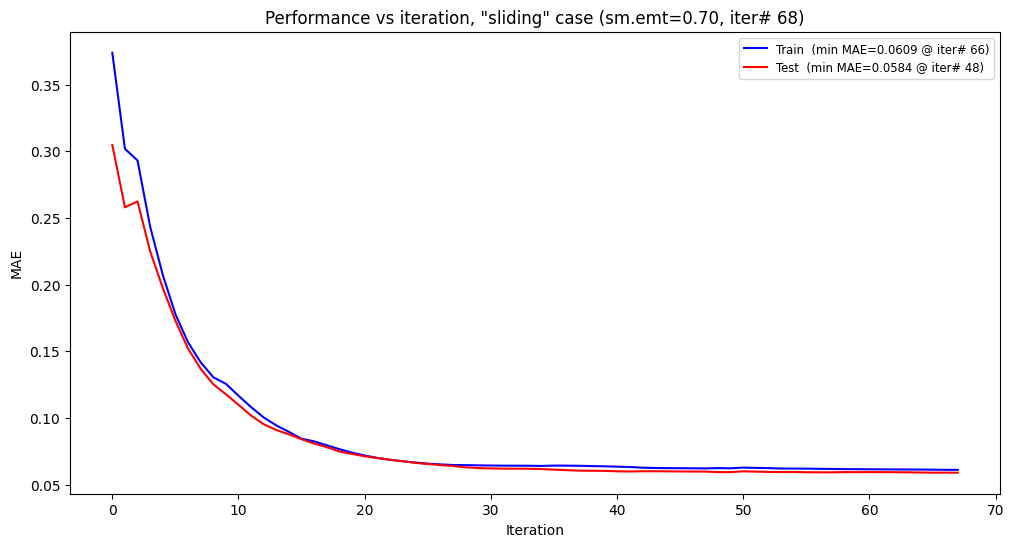

In [67]:
### Plot the MAE score
multi_perform_plot([train_mae_scores, test_mae_scores], log_interv=log_interval, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.7, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='MAE', ylabel='MAE', xlabel='Iteration',
    meas_min=True, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/mae_train_vs_test.eps')

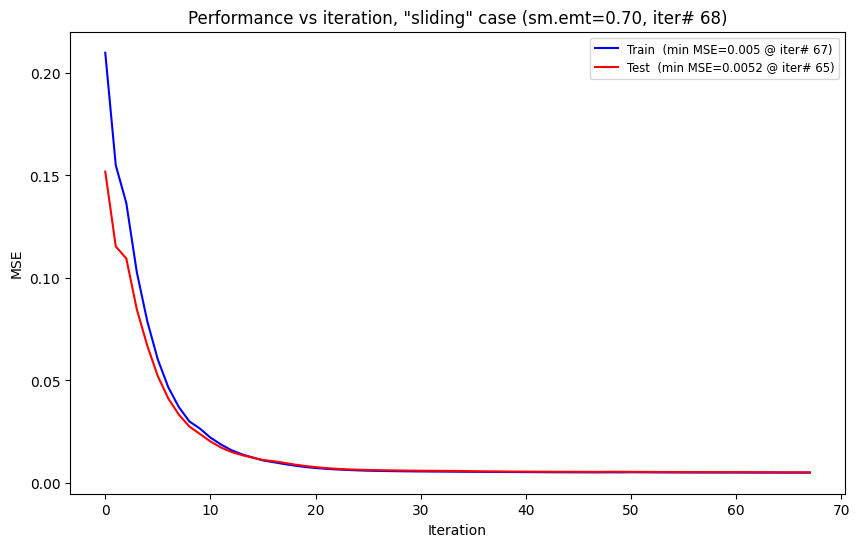

In [68]:
### Plot the MSE score
multi_perform_plot([train_mse_scores, test_mse_scores], log_interv=log_interval, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.7, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='MSE', ylabel='MSE', xlabel='Iteration',
    meas_min=True, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/mse_train_vs_test.eps')

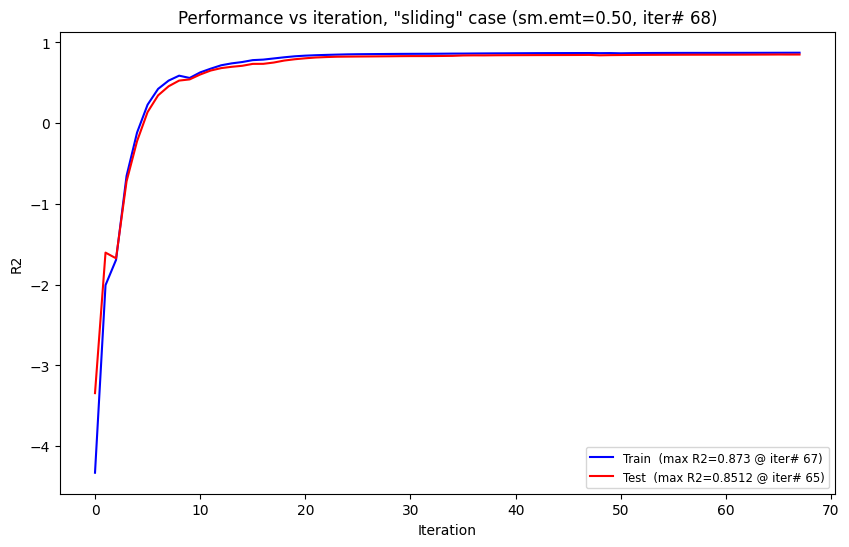

In [69]:
### Plot the R2 score
multi_perform_plot([train_r2_scores, test_r2_scores], log_interv=log_interval, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.5, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='R2', ylabel='R2', xlabel='Iteration',
    meas_min=False, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/r2_train_vs_test.eps')



TS noise = 0%, calculated noise in differenced TS = 8.18%, total noise = 2.8138, over the points = 46



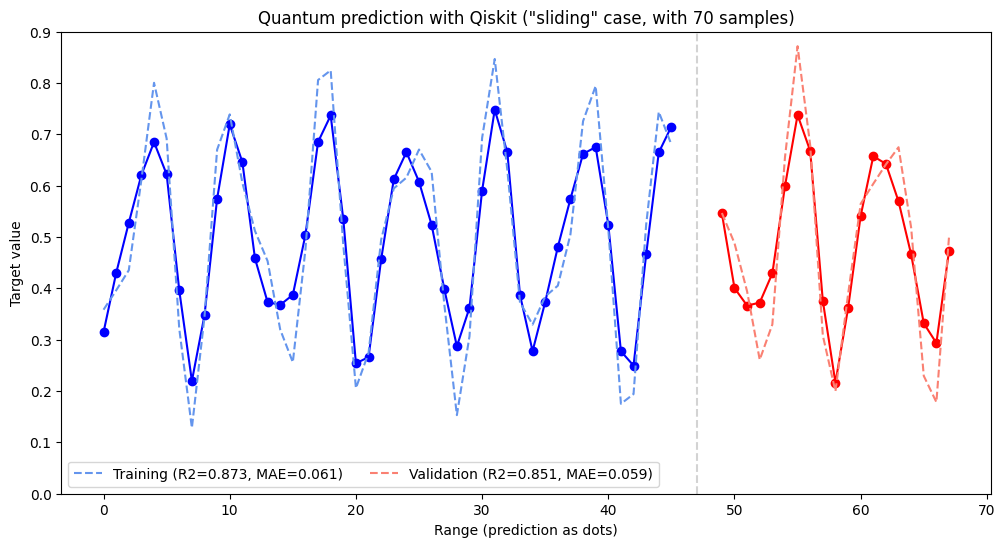

In [77]:
##### Plot selected fit
sel_params_no = 65 // log_interval

### Define model, its parameters and their values
model, input_params, weight_params, ilayers = swindow_serial_model(qubits, inputs, xlayers, ent=ent)
sel_weights = params_vals[param_no]

sel_qnn = EstimatorQNN(
    circuit=model,
    input_params=model.parameters[:inputs],
    weight_params=model.parameters[inputs:],
    observables=op, # [op1, op2],
    estimator=estimator
)

### Calculate results
start = time.time()

yp_train_true = y_train_ts
yp_valid_true = y_valid_ts
yp_train_hat = sel_qnn.forward(X_train_ts, sel_weights)
yp_valid_hat = sel_qnn.forward(X_valid_ts, sel_weights)

elapsed = time.time() - start

### Score results
train_r2 = np.round(r2_score(yp_train_true, yp_train_hat), 4)
train_mse = np.round(mean_squared_error(yp_train_true, yp_train_hat), 4)
test_r2 = np.round(r2_score(yp_valid_true, yp_valid_hat), 4)
test_mse = np.round(mean_squared_error(yp_valid_true, yp_valid_hat), 4)

### Plot data

itg_integrated_plot(y_train_ts, y_valid_ts, yp_train_hat.reshape(y_train_ts.shape), 
     yp_valid_hat.reshape(y_valid_ts.shape), wind_step, 0,
     labels=[f'Training (R2={np.round(train_r2, 3)}, MAE={np.round(train_mae, 3)})', f'Validation (R2={np.round(valid_r2, 3)}, MAE={np.round(valid_mae, 3)})'], 
     xlabel='Range (prediction as dots)', ylabel='Target value', ylim=(0, 0.9),
     title=f'Quantum prediction with Qiskit ("{CASE_NAME}" case, with {samples} samples)',
     line_styles={'train_pure':'dashed', 'train_noisy':'solid', 'valid_pure':'dashed', 'valid_noisy':'solid'},
     cols = {'train_pure':'cornflowerblue', 'train_noisy':'blue', 'valid_pure':'salmon', 'valid_noisy':'red'},
     marker_style='o', save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/qiskit_fit_{sel_params_no*log_interval:03}.eps')

## Save training data

In [78]:
### Training info files 
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/hist.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}/params.arr'
train_info_fpath

'log_2/training/sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60/info.json'

In [79]:
## Save training parameters
### Save info details
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_name':DATA_NAME,
     'data_sample':samples,
     'data_split':train_pc,
     'data_noise':noise,
     'ansatz_qubits':model.num_qubits,
     'ansatz_inputs':inputs,
     'ansatz_xlayers':xlayers,
     'log_interv':log_interval,
     'opt_name':opt_name,
     'epochs':epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "log_2/training/sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60/info.json":

	info[case_name] = sliding
	info[major_version] = 9
	info[minor_version] = 0
	info[data_name] = 2_sins_sw
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0
	info[ansatz_qubits] = 3
	info[ansatz_inputs] = 5
	info[ansatz_xlayers] = 2
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 60
	info[shots] = 10000
	info[seed] = 2022



In [80]:
### Save the history file, init and training parameters
write_ts_file(init_fpath, init_weights)
write_ts_file(history_fpath, regr_callback.objfun_vals)
write_ts_file(params_fpath, regr_callback.params_vals)
print(f'Saved data shapes: init_weights={init_weights.shape}; '+\
      f'objfun_vals=({len(regr_callback.objfun_vals)},); '+\
      f'params_vals=({len(regr_callback.params_vals)}, {len(regr_callback.params_vals[0])})')

Saved data shapes: init_weights=(88,); objfun_vals=(68,); params_vals=(68, 88)


## System

In [81]:
!pip list | grep -e qiskit -e torch

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
